# K-armed bandits

Consider the following learning problem. You are faced repeatedly with a choice among k different options, or actions. After each choice you receive a numerical reward chosen from a stationary probability
distribution that depends on the action you selected. Your objective is to maximize the expected total
reward over some time period, for example, over 1000 action selections, or time steps.

IDEA:
One single state, multiple actions. This implies that the problem can be solved without an associative behaviour, i.e. without understanding composite sets of actions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Introduction

In this first implementation of k-armed bandits we just focus on the basics of the algorithm, without optimizing the computational time needed to perform all the operations nor the scalability of the algorithm. We define the following functions:
* reward : takes as input an action between 0 and k-1 and returns a reward that is drawn from a gaussian probability distribution of mean $r_a$ and variance 1;
* greedy policy : takes as input the estimated values for each action and returns the action whose value is the highest;
* $\epsilon$-greedy policy : same as the greedy policy with probability 1-$\epsilon$, but with probability $\epsilon$ chooses one of the possible actions at random (this enhances exploration instead of exploitation);
* update Q-value: we use the ensemble average of all the rewards received choosing action $k$, i.e. $Q_{k,n+1} = \frac {\sum_{i=1}^n R_{k,i}}{n}$; notice that $n = n_k$ is the number of times up to step t in which action k was choosen.

In [2]:
def reward_v0(a, true_r):
    return np.random.normal(loc = mean_r[a], scale = 1)

In [3]:
def greedy_pol_v0(q_values):
    return np.argmax(q_values)

def e_greedy_pol_v0(q_values, eps = 0.2):
    u = np.random.rand()
    if u > eps:
        return np.argmax(q_values)
    else:
        return np.random.randint(0, len(q_values))

In [4]:
def update_q_v0(a, action_reward_memory, q_values):
    # select only action-reward for action a
    mask = (action_reward_memory[0] == a)
    # look at the rewards
    a_rewards = action_reward_memory[1][mask]
    # compute the expected value as the average over all the rewards
    q_values[a] = a_rewards.mean()
    # return updated q-values
    return q_values

## Greedy

In [5]:
# constants
steps = 1000
k = 10

# average reward for each bandit
mean_r = np.random.normal(size = k)

#memories
action_reward_memory = np.zeros(shape = (2,steps))
# for actions that have not yet been taken
action_reward_memory[0] = -1

# q-values
Q = 0 # use like 5 to be initially optimistic and enhancing greedy policy exploration
q_values = np.full(k, Q).astype('float')

In [6]:
for i in range(steps):
    a = greedy_pol_v0(q_values)
    #print("Action choosen: ", a)
    r = reward_v0(a, mean_r)
    #print("Reward obtained: ", r)
    action_reward_memory[0,i] = a
    action_reward_memory[1,i] = r
    #print("Action-reward memorized: ", action_reward_memory[:,i])
    q_values = update_q_v0(a, action_reward_memory, q_values)
    #print("Q-values: ", q_values)

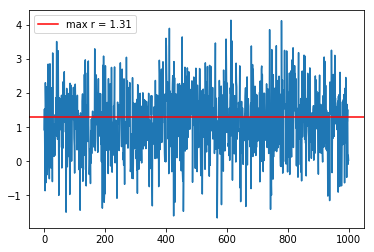

In [7]:
plt.plot(action_reward_memory[1,:])
plt.axhline(mean_r.max(), color = 'red', label = 'max r = %.2f'%mean_r.max())
plt.legend()
plt.show()

## $\epsilon$ - greedy

In [8]:
# constants
steps = 1000
k = 10

# average reward for each bandit
mean_r = np.random.normal(size = k)

#memories
action_reward_memory = np.zeros(shape = (2,steps))
# for actions that have not yet been taken
action_reward_memory[0] = -1

# q-values
Q = 0 # use like 5 to be initially optimistic and enhancing greedy policy exploration
q_values = np.full(k, Q).astype('float')

In [9]:
for i in range(steps):
    a = e_greedy_pol_v0(q_values)
    #print("Action choosen: ", a)
    r = reward_v0(a, mean_r)
    #print("Reward obtained: ", r)
    action_reward_memory[0,i] = a
    action_reward_memory[1,i] = r
    #print("Action-reward memorized: ", action_reward_memory[:,i])
    q_values = update_q_v0(a, action_reward_memory, q_values)
    #print("Q-values: ", q_values)

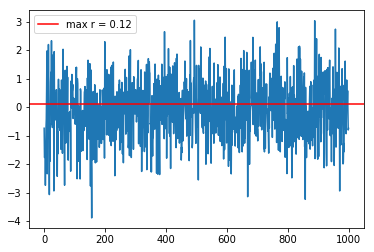

In [10]:
plt.plot(action_reward_memory[1,:])
plt.axhline(mean_r.max(), color = 'red', label = 'max r = %.2f'%mean_r.max())
plt.legend()
plt.show()

# 2 - More runs

Use 1000 runs with different initializations to compare optimistic greedy policy and $\epsilon$-greedy.
To do that we average over the runs the reward obtained at each timestep t. In order to do that efficiently all the functions are rewritten in a vectorized way.

In [69]:
def reward_v1(a, true_r):
    k = len(true_r[1])
    runs = len(true_r)
    
    # this time a is a vector and for each row r from 0 to runs-1 we have to select the mean of the a[r]-th gaussian
    # this is done creating a matrix of indexes from 0 to k-1 in each row and 'runs' rows and then filtering it with
    # another matrix that is again of shape runs x k and contains the vector a replicated k times
    index = np.tile(np.arange(0,k), (runs,1) )
    mask = (index == np.tile(a, (k,1)).T)
    selected_r = true_r[mask]

    #return np.random.normal(loc = selected_r[a], scale = 1 )
    return np.random.normal(loc = selected_r, scale = 1 )

In [70]:
def greedy_pol_v1(q_values):
    # here we choose the index corresponding to the max for each row, i.e. each run
    return np.argmax(q_values, axis = 1)

def e_greedy_pol_v1(q_values, eps = 0.2):
    actions = np.argmax(q_values, axis = 1)
    random_actions = np.random.randint(0, len(q_values[0]), size = len(q_values))
    u = np.random.rand(len(q_values))
    mask = u > eps # if u > 0 make a greedy action else a random one
    return actions

In [71]:
def update_q_v1(a, action_memory, reward_memory, q_values):
    
    # constants of the algorithm
    steps = len(action_memory[0])
    runs = len(q_values)
    k = len(q_values[0])
    
    # mask to select for each row only the actions/rewards for that given action
    mask1 = (action_memory == np.tile(a, (steps,1)).T)
    # make a copy of the matrix of the rewards for all steps and rows
    reward_copy = reward_memory.copy()
    # set to zero all the entries not associated with action a
    reward_copy[~mask1] = 0
    # compute by rows the total review 
    tot_rew = reward_copy.sum(axis = 1)
    # compute by rows the number of times that action 'a' has been selected
    tot_elements = mask1.sum(axis = 1)
    # compute the mean that is our average value Q for action a
    mean_rews = tot_rew / tot_elements
    # similar to what we have done with the reward function, we need to insert each value of the array mean_rews
    # in the corresponding position a of the q_values matrix
    index = np.tile(np.arange(0,k), (runs,1) )
    mask2 = (index == np.tile(a, (k,1)).T)
    q_values[mask2] = mean_rews

    return q_values

In [72]:
#@@@@@@@@@@@@@@@@
#greedy algorithm
#@@@@@@@@@@@@@@@@

runs = 100
steps = 2000
k = 10
# average reward for each bandit
all_mean_r = np.random.normal(size = (runs,k))

#memories
action_memory = np.full((runs,steps), -1) # for actions that have not yet been taken set a=-1
reward_memory = np.zeros(shape = (runs,steps))

# q-values
Q = 5 # use like 5 to be initially optimistic and enhancing greedy policy exploration
q_values = np.full((runs,k), Q).astype('float')

from tqdm import tnrange

for i in tnrange(steps):
    a = greedy_pol_v1(q_values)
    r = reward_v1(a, all_mean_r)
    action_memory[:,i] = a
    reward_memory[:,i] = r
    q_values = update_q_v1(a, action_memory, reward_memory, q_values)

In [75]:
#@@@@@@@@@@@@@@@@@@@@
#eps-greedy algorithm
#@@@@@@@@@@@@@@@@@@@@

runs = 100
steps = 2000
k = 10
# average reward for each bandit
all_mean_r = np.random.normal(size = (runs,k))
#print(all_mean_r.shape)

#memories
e_action_memory = np.full((runs,steps), -1) # for actions that have not yet been taken set a=-1
e_reward_memory = np.zeros(shape = (runs,steps))

# q-values
Q = 0 # use like 5 to be initially optimistic and enhancing greedy policy exploration
e_q_values = np.full((runs,k), Q).astype('float')

eps = 0.5 # starting value of epsilon
# generate an adaptive epsilon greedy algorithm
epsilons = np.array(list(map(lambda i : eps*np.exp(-10*i/steps), np.arange(0,steps))))
from tqdm import tnrange

for i in tnrange(steps):
    a = e_greedy_pol_v1(e_q_values, eps = epsilons[i])
    r = reward_v1(a, all_mean_r)
    e_action_memory[:,i] = a
    e_reward_memory[:,i] = r
    e_q_values = update_q_v1(a, e_action_memory, e_reward_memory, e_q_values)

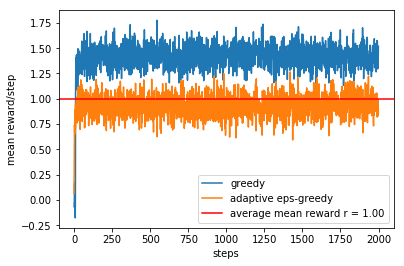

In [76]:
plt.plot(reward_memory.mean(axis = 0), label = 'greedy')
plt.plot(e_reward_memory.mean(axis = 0), label = 'adaptive eps-greedy')
plt.axhline(1, color = 'red', label = 'average mean reward r = %.2f'%1)
plt.xlabel("steps")
plt.ylabel("mean reward/step")
plt.legend()
plt.show()

# 3 - Computational issues

Now we need to use a more compact way to compute the rewards, i.e. without storing all the past information in a memory. In fact the algorithm used above here scales very badly with the number of steps:
* ~20 sec for 1000 steps and 1000 runs;
* ~ 85 sec for 2000 step and 1000 runs!

We are going to use:

$Q_{k,n+1} = Q_{k,n} + \frac{1}{n}[R_{k,n} - Q_{k,n}]$

where $k$ is the action of which we are updating the value and $n$ is the number of times that action $k$ has been chosen.

To do that we need to modify the way in which we store the experience: instead of actions and rewards at each step and the current estimates of the Q-values, we are going to store the Q-values and the counts of the number $n_a$ of times each action $a$ was selected.

The functions that we have written for the reward and the choice of the actions through the policy are left unchanged, the update function is the only one that has to be modified.

In [17]:
from sklearn import preprocessing

In [77]:
def update_q_v2(a, r, q_values, counts):
    
    # constants of the algorithm
    runs = len(q_values)
    k = len(q_values[0])

    index = np.tile(np.arange(0,k), (runs,1) )
    mask = (index == np.tile(a, (k,1)).T)
    tot_elements = np.array(counts[mask]).flatten()
    q_values[mask] = q_values[mask] + (r - q_values[mask])/tot_elements

    return q_values

In [78]:
#@@@@@@@@@@@@@@@@
#greedy algorithm
#@@@@@@@@@@@@@@@@

# constants
runs = 1000
steps = 1000
k = 10

# average reward for each bandit
all_mean_r = np.random.normal(size = (runs,k))

# we use only a memory matrix of 'runs' x k, keeping the counts of the number of times that each action has been selected
# up to current step for each run (row)
counts = np.zeros((runs,k))

# q-values
Q = 5 # use like 5 to be initially optimistic and enhancing greedy policy exploration
q_values = np.full((runs,k), Q).astype('float')

# class of sklear to encode actions in a sparse matrix to update the countings
enc = preprocessing.OneHotEncoder(sparse = True, categories='auto')
# we need to provide it all the possible integer labels that we want to encode in binary columns
enc.fit(np.arange(0,k).reshape(k,1))

score = np.zeros(runs)

from tqdm import tnrange
for i in tnrange(steps):
    a = greedy_pol_v1(q_values)
    r = reward_v1(a, all_mean_r)
    score = score + (r - score)/(i+1)
    # now we need to add the counts to the 'a'
    a_sparse = enc.transform(a.reshape(runs,1))
    counts = counts + a_sparse
    q_values = update_q_v2(a, r, q_values, counts)

average_score = score.mean()
print("Average score over %d steps : %.2f"%(steps,average_score))


Average score over 1000 steps : 1.38


In [79]:
#@@@@@@@@@@@@@@@@
#eps-greedy algorithm
#@@@@@@@@@@@@@@@@

# constants
runs = 1000
steps = 1000
k = 10

# average reward for each bandit
all_mean_r = np.random.normal(size = (runs,k))

# we use only a memory matrix of 'runs' x k, keeping the counts of the number of times that each action has been selected
# up to current step for each run (row)
e_counts = np.zeros((runs,k))

# q-values
Q = 0 # use like 5 to be initially optimistic and enhancing greedy policy exploration
e_q_values = np.full((runs,k), Q).astype('float')

# class of sklear to encode actions in a sparse matrix to update the countings
enc = preprocessing.OneHotEncoder(sparse = True, categories='auto')
# we need to provide it all the possible integer labels that we want to encode in binary columns
enc.fit(np.arange(0,k).reshape(k,1))

eps = 0.5 # starting value of epsilon
# generate an adaptive epsilon greedy algorithm
epsilons = np.array(list(map(lambda i : eps*np.exp(-3*i/steps), np.arange(0,steps))))

e_score = np.zeros(runs)

from tqdm import tnrange
for i in tnrange(steps):
    a = e_greedy_pol_v1(e_q_values, eps = epsilons[i])
    r = reward_v1(a, all_mean_r) # this can be memorized apart for benchmarking
    e_score = e_score + (r - e_score)/(i+1)
    # now we need to add the counts to the 'a'
    a_sparse = enc.transform(a.reshape(runs,1))#.reshape((runs,k))
    #print(a_sparse.shape)
    e_counts = e_counts + a_sparse
    e_q_values = update_q_v2(a, r, e_q_values, e_counts)

e_average_score = e_score.mean()
print("Average score over %d steps : %.2f"%(steps, e_average_score))


Average score over 1000 steps : 1.00


# Towards MDP: two states k-armed bandits

State A and B, each of them is a k-armed bandits problem to be learned with different results.

To solve this problem we just need to double what we have done since now and specify at each time which is the state that we are in.

The state is choosen randomly from the environment and doesn't depend on the action that we have taken. In this sense we don't search for an optimal composition of actions, but just how to learn a problem with two independent states.

In [106]:
#@@@@@@@@@@@@@@@@
#greedy algorithm
#@@@@@@@@@@@@@@@@

# constants
runs = 1000
steps = 2000
k = 10
n_states = 2

# average reward for each bandit
all_mean_r = np.array([np.random.normal(size = (runs,k)) for i in range(n_states)])

# we use only a memory matrix of 'runs' x k, keeping the counts of the number of times that each action has been selected
# up to current step for each run (row)
counts = np.zeros((n_states,runs,k))

# q-values
Q = 5 # use like 5 to be initially optimistic and enhancing greedy policy exploration
q_values = np.full((n_states,runs,k), Q).astype('float')

# class of sklear to encode actions in a sparse matrix to update the countings
enc = preprocessing.OneHotEncoder(sparse = True, categories='auto')
# we need to provide it all the possible integer labels that we want to encode in binary columns
enc.fit(np.arange(0,k).reshape(k,1))

score = np.zeros((n_states,runs))
s = 0 # initial state
from tqdm import tnrange
for i in tnrange(steps):
    a = greedy_pol_v1(q_values[s])
    r = reward_v1(a, all_mean_r[s])
    
    # the score is the average reward for each state
    score[s] = score[s] + (r - score[s])/(counts[s].sum() / runs +1)
    # now we need to add the counts to the 'a'
    a_sparse = enc.transform(a.reshape(runs,1))
    counts[s] = counts[s] + a_sparse
    
    # update the value
    q_values[s] = update_q_v2(a, r, q_values[s], counts[s])
    
    # update the state
    u = np.random.rand()
    if u < 0.5:
        s = 0
    else:
        s = 1
        
average_score = score.mean(axis = 1)
print("Average score over %d steps for states [0,1] : "%(steps),average_score)
print("Optimal score : ", np.mean(all_mean_r.max(axis = (2)), axis = 1))


Average score over 2000 steps for states [0,1] :  [1.41979113 1.4050033 ]
Optimal score :  [1.55576003 1.53394557]


In [107]:
#@@@@@@@@@@@@@@@@
#eps-greedy algorithm
#@@@@@@@@@@@@@@@@

# constants
runs = 1000
steps = 1000
k = 10
n_states = 2

# average reward for each bandit
all_mean_r = np.array([np.random.normal(size = (runs,k)) for i in range(n_states)])

# we use only a memory matrix of 'runs' x k, keeping the counts of the number of times that each action has been selected
# up to current step for each run (row)
e_counts = np.zeros((n_states,runs,k))

# q-values
Q = 0 # use like 5 to be initially optimistic and enhancing greedy policy exploration
e_q_values = np.full((n_states,runs,k), Q).astype('float')

# class of sklear to encode actions in a sparse matrix to update the countings
enc = preprocessing.OneHotEncoder(sparse = True, categories='auto')
# we need to provide it all the possible integer labels that we want to encode in binary columns
enc.fit(np.arange(0,k).reshape(k,1))

eps = 0.5 # starting value of epsilon
# generate an adaptive epsilon greedy algorithm
epsilons = np.array(list(map(lambda i : eps*np.exp(-3*i/steps), np.arange(0,steps))))

e_score = np.zeros((n_states,runs))

from tqdm import tnrange
for i in tnrange(steps):
    a = e_greedy_pol_v1(e_q_values[s], eps = epsilons[i])
    r = reward_v1(a, all_mean_r[s]) # this can be memorized apart for benchmarking
    e_score[s] = e_score[s] + (r - e_score[s])/(e_counts[s].sum() / runs +1)
    # now we need to add the counts to the 'a'
    a_sparse = enc.transform(a.reshape(runs,1))#.reshape((runs,k))
    #print(a_sparse.shape)
    e_counts[s] = e_counts[s] + a_sparse
    e_q_values[s] = update_q_v3(a, r, e_q_values[s], e_counts[s])
    
        # update the state
    u = np.random.rand()
    if u < 0.5:
        s = 0
    else:
        s = 1

e_average_score = e_score.mean(axis = 1)
print("Average score over %d steps for states [0,1] :"%(steps), e_average_score)
print("Optimal score : ", np.mean(all_mean_r.max(axis = (2)), axis = 1))


Average score over 1000 steps for states [0,1] : [1.03988708 0.99160816]
Optimal score :  [1.54573611 1.54663242]
